In [7]:
!nvidia-smi

Sat Dec 11 22:16:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    35W / 250W |    377MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get helper functions
Dowload the helper functions from [Github](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py) and import them to the notebook.


In [8]:
# get helper functions 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-12-11 22:16:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-11 22:16:33 (91.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [9]:
# import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

# Download Dataset from TensorFlow Datasets (TFDS)


In [10]:
# import TFDS
import tensorflow_datasets as tfds

#list all available datasets
datasets_list = tfds.list_builders()
datasets_list

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

In [5]:
#load in food101 dataset from tfds
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteDTTMUK/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteDTTMUK/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


# Explore the Food 101 dataset from TFDS

In [6]:
# check features of food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [11]:
# get class names
class_names = ds_info.features['label'].names
# check the first 10 class names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101: 56
  Class name: huevos_rancheros
  


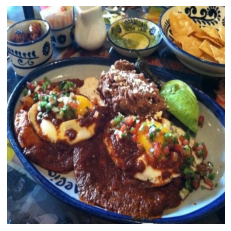

In [12]:
# take one sample of the training data
train_one_sample = train_data.take(1)

# output shape, datatype, taget class, class name of one training data sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101: {label}
  Class name: {class_names[label.numpy()]}
  """)

# plot a image of the dataset
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis(False);

# Preprocess the data

In [13]:
# import TensorFlow
import tensorflow as tf

# create a function to preprocess the images
def preprocess_img(image, label, img_shape=224):
  """
  convert image datatype from 'uint8' to 'float32'
  and reshape image to the size of [img_shape, img_shape, color_channels]
  """
  # reshape target image
  image = tf.image.resize(image, [img_shape, img_shape])
  # return (float32_image, label) tuple
  return tf.cast(image, tf.float32), label


In [14]:
preprocessed_img = preprocess_img(image, label)[0]

In [15]:
# print image info before and after preprocessing
print(f"""
image before preprocess: 
{image[:2]}
shape: {image.shape}
datatype: {image.dtype}

image after preprocess: 
{preprocessed_img[:2]}
shape: {preprocessed_img.shape}
datatype: {preprocessed_img.dtype}
""")



image before preprocess: 
[[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]
shape: (512, 512, 3)
datatype: <dtype: 'uint8'>

image after preprocess: 
[[[230.65816  253.64285  251.      ]
  [222.99998  254.97449  252.19388 ]
  [207.06633  255.       250.36734 ]
  ...
  [140.66287  129.52519  121.22428 ]
  [121.14268  115.265144 116.95397 ]
  [ 83.95363   83.08119   89.63737 ]]

 [[221.47449  254.37755  253.33163 ]
  [214.5102   255.       253.92348 ]
  [198.41327  254.58673  251.96939 ]
  ...
  [208.66318  195.82143  173.40823 ]
  [197.03056  190.1071   174.83162 ]
  [175.54036  171.6169   161.21384 ]]]
shape: (224, 224, 3)
datatype: <dtype: 'float32'>



# Batch and Prepare the data

In [16]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

# Create modelling callbacks

In [18]:
# create modelcheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

# Setup mixed precision training
 (Google Colab's GPU might not support it)

In [19]:
# turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


# Build feature extraction model

In [20]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [21]:
# compile the model
model.compile(loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

# Fit the feature extraction model

In [23]:
# fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=5,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101/20211211-221638
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - ETA: 0s - loss: 1.8213 - accuracy: 0.5579WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 133s 49ms/step - loss: 1.8213 - accuracy: 0.5579 - val_loss: 1.2278 - val_accuracy: 0.6756
Epoch 2/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.2949 - accuracy: 0.6665WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 114s 47ms/step - loss: 1.2949 - accuracy: 0.6665 - val_loss: 1.1279 - val_accuracy: 0.7005
Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 1.1456 - accuracy: 0.7008WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 114s 48ms/step - loss: 1.1456 - accuracy: 0.7008 - val_loss: 1.0954 - val_accuracy: 0.7105
Epoch 4/5
2368/2368 [==============================] - ETA: 0s - loss: 1.0471 - accuracy: 0.7259WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 114s 48ms/step - loss: 1.0471 - accuracy: 0.7259 - val_loss: 1.0754 - val_accuracy: 0.7135
Epoch 5/5
2367/2368 [============================>.] - ETA: 0s - loss: 0.9737 - accuracy: 0.7457WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 113s 47ms/step - loss: 0.9737 - accuracy: 0.7457 - val_loss: 1.0619 - val_accuracy: 0.7105


In [24]:
# evaluate the feature extraction model
model.evaluate(test_data)

790/790 [==============================] - 34s 42ms/step - loss: 1.0707 - accuracy: 0.7118


[1.0706754922866821, 0.7118415832519531]

# Save the whole model to file

In [25]:
model.save("food_101_feature_extraction_model")

INFO:tensorflow:Assets written to: food_101_feature_extraction_model/assets


INFO:tensorflow:Assets written to: food_101_feature_extraction_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [26]:
# Load model previously saved above
loaded_model = tf.keras.models.load_model("food_101_feature_extraction_model")

In [27]:
# Check loaded model performance
loaded_model.evaluate(test_data)

790/790 [==============================] - 36s 43ms/step - loss: 1.0707 - accuracy: 0.7118


[1.0706754922866821, 0.7118415832519531]

# Preparing model's layers for fine-tuning
Fine-tune the feature extraction model to beat the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf).

In [28]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2021-12-11 22:28:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  99.0MB/s    in 0.2s    

2021-12-11 22:28:56 (99.0 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [29]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [30]:
# Load and evaluate downloaded GS model
downloaded_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [31]:
# Get a summary of the downloaded model
downloaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [32]:
# How does the loaded model perform? (evaluate it on the test dataset)
downloaded_model.evaluate(test_data)

790/790 [==============================] - 35s 43ms/step - loss: 1.0881 - accuracy: 0.7067


[1.0880929231643677, 0.7066534757614136]

In [33]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
for layer in downloaded_model.layers:
  layer.trainable = True

In [34]:
# Check to see what dtype_policy of the layers in your loaded model are
for layer in downloaded_model.layers:
  print(layer.name, layer.dtype_policy)

input_layer <Policy "float32">
efficientnetb0 <Policy "mixed_float16">
pooling_layer <Policy "mixed_float16">
dense <Policy "mixed_float16">
softmax_float32 <Policy "float32">


In [35]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True)

In [36]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
downloaded_model.compile(loss="sparse_categorical_crossentropy",
                         optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                         metrics=["accuracy"])

In [37]:
# Start to fine-tune (all layers)
# Use 10 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier

downloaded_model_history = downloaded_model.fit(train_data,
                                                epochs=10,
                                                validation_data=test_data,
                                                validation_steps=int(0.15 * len(test_data)), 
                                                initial_epoch=history_101_food_classes_feature_extract.epoch[-1],
                                                callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                       experiment_name="efficientnetb0_101"),
                                                           model_checkpoint_callback, 
                                                           callback])

Saving TensorBoard log files to: training_logs/efficientnetb0_101/20211211-222951
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 432s 175ms/step - loss: 0.9223 - accuracy: 0.7538 - val_loss: 0.7913 - val_accuracy: 0.7847
Epoch 6/10
2368/2368 [==============================] - 417s 175ms/step - loss: 0.5682 - accuracy: 0.8427 - val_loss: 0.7900 - val_accuracy: 0.7831
Epoch 7/10
2368/2368 [==============================] - 412s 173ms/step - loss: 0.3129 - accuracy: 0.9114 - val_loss: 0.9392 - val_accuracy: 0.7669
Epoch 8/10
2368/2368 [==============================] - 411s 173ms/step - loss: 0.1613 - accuracy: 0.9530 - val_loss: 1.0188 - val_accuracy: 0.7797
Epoch 9/10
2368/2368 [==============================] - 409s 172ms/step - loss: 0.1056 - accuracy: 0.9676 - val_loss: 1.1463 - val_accuracy: 0.7624


In [38]:
# Save model locally
downloaded_model.save("food_101_feature_extraction_model_fine_tuned")

INFO:tensorflow:Assets written to: food_101_feature_extraction_model_fine_tuned/assets


INFO:tensorflow:Assets written to: food_101_feature_extraction_model_fine_tuned/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [39]:
# Evaluate mixed precision trained fine-tuned model
downloaded_model.evaluate(test_data)

790/790 [==============================] - 34s 43ms/step - loss: 1.1862 - accuracy: 0.7568


[1.1862114667892456, 0.756831705570221]

# View training results on TensorBoard
Upload and view your model's training results to TensorBoard.dev and view them.

In [40]:
!tensorboard dev upload --logdir ./training_logs/ \
  --name "efficientnetb0_101" \
  --description "efficientnetb0_101 after fine-tuning" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=PMBERaMpzB0pyw90wLb39askLFWFDY&prompt=consent&access_type=offl

# Evaluate your trained model
Some ideas you might want to go through:

- Find the precision, recall and f1 scores for each class (all 101).
- Build a confusion matrix for each of the classes.
- Find your model's most wrong predictions (those with the highest prediction probability but the wrong prediction).


In [41]:
# use the model to make predictions
pred_probs = downloaded_model.predict(test_data, verbose=1)

790/790 [==============================] - 35s 41ms/step


In [42]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

pred_classes[:10]

array([29, 81, 91, 53, 97, 97, 10, 31,  3, 58])

## Visualize custom images



In [67]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2021-12-11 23:48:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.2’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.05s   

2021-12-11 23:48:40 (235 MB/s) - ‘custom_food_images.zip.2’ saved [13192985/13192985]



In [69]:
from helper_functions import unzip_data
unzip_data("custom_food_images.zip")

In [70]:
# Get the custom food images filepaths
import os
custom_food_images = ["custom_food_images/" + i for i in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg']

In [71]:
# Create a function to load and prepare images
def preprocessed_image(filepath, img_shape=224, scale=True):
  """
  Reads in an image from filepath, turns it into a tensor and reshapes into
  specified shape (img_shape,img_shape,color channels=3)

  Args:
  filepath (str): path to target image
  img_shape (int): height/width dimension of target image size
  scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
  Image tensor of shape (img_shape,img_shape,3)
  """
  # Read in the image
  img = tf.io.read_file(filepath)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape,img_shape])

  # Rescale the image (Yes/No)
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow

In [72]:
custom_food_images_names = [i for i in os.listdir("custom_food_images")]
custom_food_images_names

['steak.jpeg',
 'hamburger.jpeg',
 'pizza-dad.jpeg',
 'chicken_wings.jpeg',
 'sushi.jpeg',
 'ramen.jpeg']

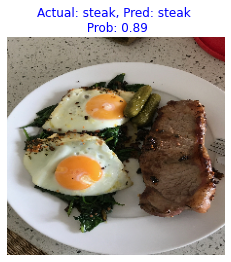

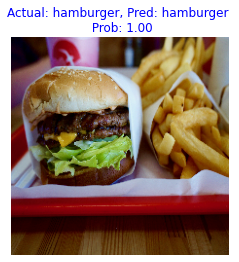

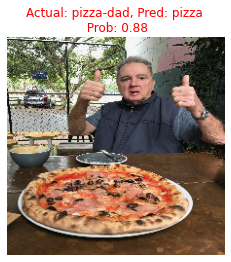

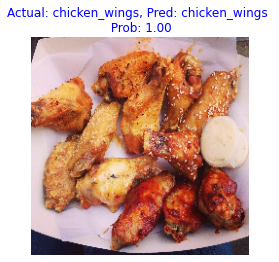

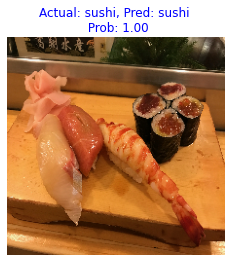

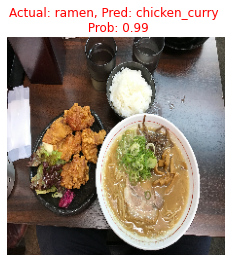

In [74]:
# Make predictions on and plot custom food images
for i,path in enumerate(custom_food_images):
  img = preprocessed_image(path,scale=False)
  pred = downloaded_model.predict(tf.expand_dims(img,axis=0))
  pred_class_name = class_names[pred.argmax()]
  if custom_food_images_names[i].rstrip('.jpeg') == pred_class_name:
    color='blue'
  else:
    color='red'
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"Actual: {custom_food_images_names[i].rstrip('.jpeg')}, Pred: {pred_class_name} \n Prob: {pred.max():.2f}",color=color)
  plt.axis(False);